In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor


In [28]:
df = pd.read_csv("sales_data.txt")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(["store_id", "sku_id", "date"])

In [29]:
for lag in [1, 7, 14]:
    df[f'lag_{lag}'] = df.groupby(
        ['store_id','sku_id']
    )['sales'].shift(lag)

df['rolling_7'] = df.groupby(
    ['store_id','sku_id']
)['sales'].shift(1).rolling(7).mean()

df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dow'] = df['date'].dt.dayofweek

In [30]:
le_store = LabelEncoder()
le_sku = LabelEncoder()

df['store_enc'] = le_store.fit_transform(df['store_id'])
df['sku_enc'] = le_sku.fit_transform(df['sku_id'])

In [31]:
# df.dropna(inplace=True) # Commented out as it causes the DataFrame to become empty with a small dataset after creating lag features. XGBoost can handle NaNs by default.

In [36]:
split_date = df['date'].max() - pd.Timedelta(days=30)
train = df[df['date'] < split_date]
test  = df[df['date'] >= split_date]

features = [
    'lag_1','lag_7','lag_14',
    'rolling_7',
    'month','day','dow',
    'promotion','price',
    'store_enc','sku_enc'
]

X_train = train[features]
y_train = train['sales']

X_test = test[features]
y_test = test['sales']

In [37]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [38]:
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

MAE: 22.600000381469727


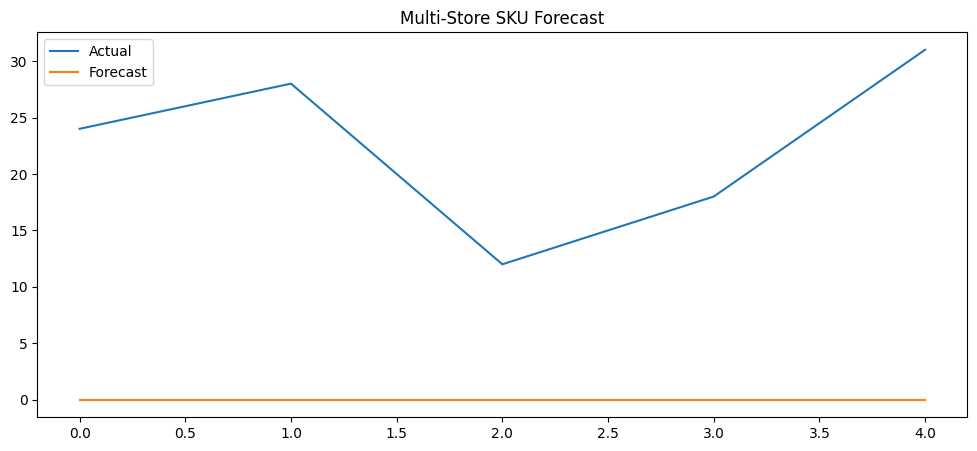

In [39]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(preds[:200], label="Forecast")
plt.legend()
plt.title("Multi-Store SKU Forecast")
plt.show()